In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import tensor
import swyft

from forward import *

In [2]:
# define prior chunks
global_low_list = [60.0]
global_high_list = [80.0]
# nobs_low_list = [0.0]*((k+1)*n_nobs)
# obs_low_list = [0.0]*(k*n_obs)
# nobs_high_list = [1.0]*((k+1)*n_nobs)
# obs_high_list = [1.0]*(k*n_obs)
low_list = [0.0]*10
high_list = [1.0]*10

# append prior chunks
# low_list = global_low_list + nobs_low_list + obs_low_list
# high_list = global_high_list + nobs_high_list + obs_high_list
low_list = global_low_list + low_list
high_list = global_high_list + high_list

# instantiate prior
low = np.array(low_list)
high = np.array(high_list)
prior = swyft.get_uniform_prior(low, high)

In [12]:
observation_o = {'x': np.array([1.0])}

n_observation_features = observation_o[observation_key].shape[0]
observation_shapes = {key: value.shape for key, value in observation_o.items()}

simulator = swyft.Simulator(
    forward,
    11,
    sim_shapes=observation_shapes
)

store = swyft.Store.memory_store(simulator)

Creating new store.


In [13]:
store.add(500*6, prior)
# d1 = swyft.Dataset.load(filename='e1.dataset.pt', store=store)
# d2 = swyft.Dataset.load(filename='e2.dataset.pt', store=store)
# d3 = swyft.Dataset.load(filename='e3.dataset.pt', store=store)
# d4 = swyft.Dataset.load(filename='e4.dataset.pt', store=store)
# d5 = swyft.Dataset.load(filename='e5.dataset.pt', store=store)

d1 = torch.load('el1.dataset.pt')
d2 = torch.load('el2.dataset.pt')
d3 = torch.load('el3.dataset.pt')
d4 = torch.load('el4.dataset.pt')
d5 = torch.load('el5.dataset.pt')

Store: Adding 2922 new samples to simulator store.


In [14]:
dT = d1 + d2 + d3 + d4 + d5
# len(d3), len(d4), len(d5)
len(dT), dT[101]

(2500,
 ({'x': tensor([-30.])},
  tensor([0.5977, 0.6693, 0.3767, 0.0962, 0.2357, 0.3835, 0.1770, 0.9537, 0.5030,
          0.8948, 0.8600]),
  tensor([73.9657,  0.6693,  0.3767,  0.0962,  0.2357,  0.3835,  0.1770,  0.9537,
           0.5030,  0.8948,  0.8600])))

In [18]:
marginal_indices_1d, marginal_indices_2d = swyft.utils.get_corner_marginal_indices(11)


network_1d = swyft.get_marginal_classifier(
    observation_key=observation_key,
    marginal_indices=marginal_indices_1d,
    observation_shapes=observation_shapes,
    n_parameters=11,
    hidden_features=32,
    num_blocks=2,
)
mre_1d = swyft.MarginalRatioEstimator(
    marginal_indices=marginal_indices_1d,
    network=network_1d,
    device=device,
)

mre_1d.train(dT)

training: lr=5e-06, epoch=25, validation loss=15.221


[tensor(15.2481),
 tensor(15.2356),
 tensor(15.2294),
 tensor(15.2244),
 tensor(15.2209),
 tensor(15.2190),
 tensor(15.2141),
 tensor(15.2196),
 tensor(15.2109),
 tensor(15.2085),
 tensor(15.2093),
 tensor(15.2135),
 tensor(15.2138),
 tensor(15.2237),
 tensor(15.2225),
 tensor(15.2131),
 tensor(15.2114),
 tensor(15.2141),
 tensor(15.2149),
 tensor(15.2154),
 tensor(15.2157),
 tensor(15.2158),
 tensor(15.2155),
 tensor(15.2155),
 tensor(15.2155)]

producing posterior
sampling


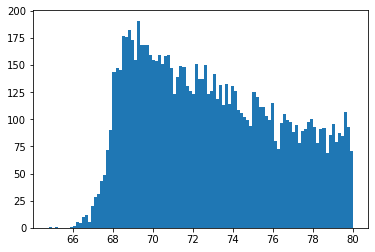

In [19]:
n_rejection_samples = 10000

print("producing posterior")

posterior_1d = swyft.MarginalPosterior(mre_1d, prior)

print("sampling")

samples_1d = posterior_1d.sample(n_rejection_samples, observation_o)
key = marginal_indices_1d[0]

plt.hist(samples_1d[key], 100)
plt.show()

In [15]:
nd = len(dT)
S = []
H0 = []
dT_trim = []
v5 = []
for i in range(nd):
    if np.isnan(dT[i][0]['x'].numpy()):
        print(dT[i])
        dT[i][0]['x'] = tensor([-30.0])
    if dT[i][0]['x'].numpy()[0] != -30.0:
        S += [dT[i][0]['x'].numpy()]
#         v5 += [dT[i][2][5].numpy()]
        H0 += [dT[i][2][0].numpy()]
        dT_trim += [dT[i]]

({'x': tensor([nan])}, tensor([0.7787, 0.4730, 0.6542, 0.5495, 0.3814, 0.3521, 0.0163, 0.0069, 0.7356,
        0.1839, 0.2528]), tensor([7.6680e+01, 4.7303e-01, 6.5422e-01, 5.4947e-01, 3.8141e-01, 3.5208e-01,
        1.6309e-02, 6.9305e-03, 7.3561e-01, 1.8389e-01, 2.5279e-01]))
({'x': tensor([nan])}, tensor([0.9875, 0.9128, 0.5097, 0.2929, 0.2022, 0.7006, 0.8597, 0.1238, 0.8659,
        0.6459, 0.4845]), tensor([79.8120,  0.9128,  0.5097,  0.2929,  0.2022,  0.7006,  0.8597,  0.1238,
         0.8659,  0.6459,  0.4845]))


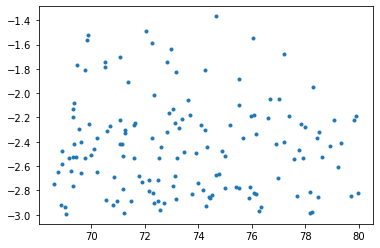

In [17]:
plt.plot(H0, np.log10(np.exp(np.asarray(S))), '.')
plt.show()

In [52]:
len(S)

786

In [21]:
torch.save(dT, 'file.pt') 

In [23]:
torch.load('file.pt')

[({'x': tensor([0.0494])},
  tensor([0.7617, 0.3067, 0.5172, 0.3937, 0.3996, 0.5365, 0.8783, 0.9976, 0.4138,
          0.6268, 0.4792, 0.5120]),
  tensor([72.6171,  0.3067,  0.5172,  0.3937,  0.3996,  0.5365,  0.8783,  0.9976,
           0.4138,  0.6268,  0.4792,  0.5120])),
 ({'x': tensor([0.])},
  tensor([0.5854, 0.3263, 0.8048, 0.4100, 0.3124, 0.6577, 0.4925, 0.6257, 0.2788,
          0.9915, 0.6286, 0.0802]),
  tensor([70.8543,  0.3263,  0.8048,  0.4100,  0.3124,  0.6577,  0.4925,  0.6257,
           0.2788,  0.9915,  0.6286,  0.0802])),
 ({'x': tensor([0.1597])},
  tensor([0.5755, 0.6918, 0.0991, 0.4142, 0.6018, 0.9322, 0.3298, 0.4872, 0.0949,
          0.4096, 0.7721, 0.4885]),
  tensor([70.7551,  0.6918,  0.0991,  0.4142,  0.6018,  0.9322,  0.3298,  0.4872,
           0.0949,  0.4096,  0.7721,  0.4885])),
 ({'x': tensor([0.0010])},
  tensor([0.7928, 0.5277, 0.4350, 0.1494, 0.9624, 0.2550, 0.0576, 0.5030, 0.1124,
          0.2812, 0.2775, 0.7341]),
  tensor([7.2928e+01, 5.2767e-0

In [24]:
from astropy import cosmology

In [26]:
u = cosmology.FlatLambdaCDM(70, 0.3)

In [38]:
u.H(-0.05)

<Quantity 68.4860661 km / (Mpc s)>